# Functions used throughout

In [2]:
%matplotlib inline
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os, re, glob
from scipy import stats



In [193]:
def compute_power(arr):  
    # used to compute power of signal and Power of Noise
    return sum([ np.abs(i)**2 for i in arr])/len(arr)


def plot_snr_density( noise_power,noisy_signal_power, ax=None,title="title"):
    if ax is None:
        ax = plt.gca()    
    computed_snr = [10*np.log10(s/n) for s,n in zip(np.array(noisy_signal_power),np.array(noise_power))]
   
    snr_density = stats.kde.gaussian_kde( computed_snr)   
    print("Some computed SNR values: ",computed_snr[1:5])
    x = np.arange(1.2*min(computed_snr), 1.2*max(computed_snr), 1e-3)
    ax.plot(x, snr_density(x))
    ax.set_title(title)
    ax.set_xlim([-4,16])
    ax.set_xlabel("SNR (dB)")
    ax.set_ylabel("Frequency")
    ax.locator_params(nbins=4)
    
def plot_density(noise_power, noisy_signal_power, ax=None, xminlesszero=False,title="title",
                 xlabel="Power (linear)", ylabel="Frequency"):
    if ax is None:
        ax = plt.gca()
    signal_power_density = stats.kde.gaussian_kde( np.array(noisy_signal_power) )
    noise_power_density = stats.kde.gaussian_kde( np.array(noise_power) )

    x = np.arange(-1.2*max(noisy_signal_power), 1.2*max(noisy_signal_power), 1e-3)

    ax.plot(x, signal_power_density(x))
    ax.plot(x, noise_power_density(x), color='r')
    ax.set_title(title)
    if xminlesszero is True: 
        ax.set_xlim([-1*max(x),max(x)])
    else:   
        ax.set_xlim([0,max(x)])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #bp = ax.legend(['output signal','noise'],  loc="upper right")
    ax.locator_params(nbins=4)

    
def plot_avg_pwr(noise_power, noisy_signal_power, ax,  title="title"):
        # plot avg power for noisy signal and nosie for pickled files of a specified db
        ax.scatter(noisy_signal_power,range(len(noisy_signal_power)), alpha=0.2)
        ax.scatter(noise_power,range(len(noise_power)), color="r", alpha=0.2)
        ax.set_xlabel("Power (linear scale)")
        ax.set_ylabel("Sample number ")
        #ax.legend(['output signal','noise'],  loc="upper right")
        ax.set_title(title)
        ax.set_xlim([0,max(noisy_signal_power)])
        ax.set_ylim([0,max(range(len(noisy_signal_power)))])
        ax.locator_params(nbins=4)
        


## Finding Alternative Features on which to classify
*Immediate TODO*
     * "point out what these tell us about M2 and M4" -- FF
     * need to regenerate samples using new script
     * fix off by 3db issue



** Intuition behind 2nd, 4th moments **

The second moment $M_{2}$  is variance, or consistancy of the signal. 
$$M_{2}\approx \frac{1}{N_{sym}} \sum_{n=0}^{N_{sym}-1} \mid y_{n}\mid^2$$

The fourth moment $M_{4}$ is called kurtosis. It correlates to how peaked your graph is and measured against the normal distribution which has a kurtosis of 3.


$$M_{4}\approx \frac{1}{N_{sym}} \sum_{n=0}^{N_{sym}-1} \mid y_{n}\mid^4$$

$a_n$ is the sequence of M-ary source symbols.
$$a_n = e^{j \theta_{n}}$$

where $\theta_{n}$ <span style="background-color: #FFFF00">"is one of the M phases spaced evenly around the unit circle" </span>(IEEE paper) 
> So $\theta$ is just one of the four symbols, right?
 
$w_{n}$ is the symbol spaced filtered noise sample.


The kurtosis of the signal, $k_{a}$. $$k_{a} =  \frac {\mathop{\mathbb{E}} \mid a_{n}\mid ^{4}} { ( \mathop{\mathbb{E}} \mid a_{n}\mid ^2 )^2 } $$


The kurtosis of noise, $k_{w}$. $$k_{w} =  \frac {\mathop{\mathbb{E}} \mid w_{n}\mid ^{4}} { ( \mathop{\mathbb{E}} \mid w_{n}\mid ^2 )^2 } $$

 ** Repeat for 4th moment. You may find it helpful to *plot the distribution of the samples themselves (density plot) for the signal and noise, respectively, and point out what these tell us about M2 and M4.***

## plot the distribution of the samples themselves (density plot) for the signal and noise, respectively


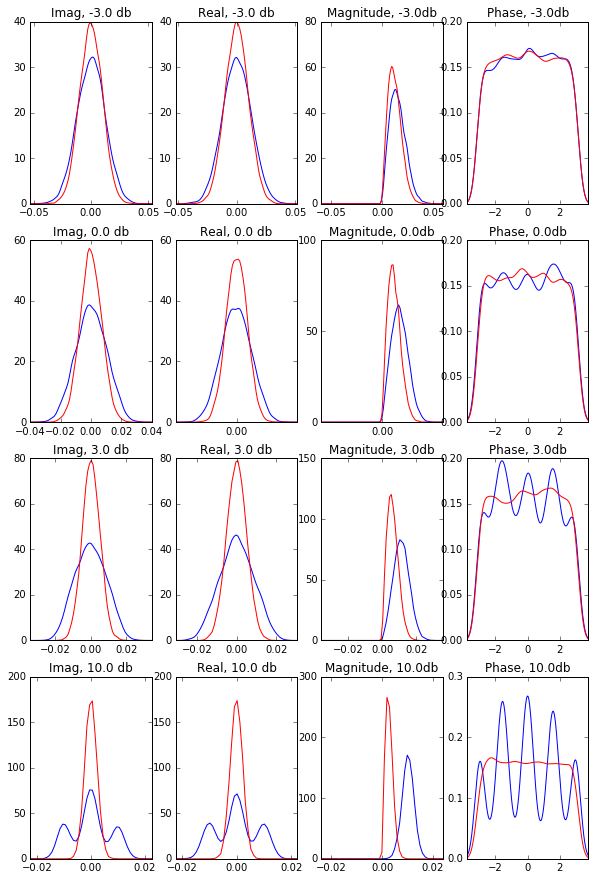

In [205]:
# plot distribution of flattened no_trials where ndata = 1024 for each value of SNR
snrlist = [-3,0,3,10] 
f2, axtuple2 = plt.subplots(len(snrlist), 4, figsize=(10, 15))
no_trials=100 # when no_trials is  100, no of flattened samples is 12800


for ax_idx, snr_desired in enumerate(snrlist):        

    noise_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_1024" + "*noise.npy"
    noise_files_1024 = [file for file in glob.glob(noise_pattern)]
    noise_samples_1024 = \
        np.ndarray.flatten(np.array([j for f in noise_files_1024 for i,j, in enumerate(np.load(f))]))[0:no_trials*128]
    
    
    sn_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_1024" + "*sn.npy"
    sn_files_1024 = [file for file in glob.glob(sn_pattern)]
    sn_samples_1024 = \
        np.ndarray.flatten(np.array([j for f in sn_files_1024 for i,j, in enumerate(np.load(f))]))[0:no_trials*128]
    
    # plot density of real part of no_trials worth of samples
    plot_density(np.real(noise_samples_1024), np.real(sn_samples_1024),
                 axtuple2[ax_idx][1],xminlesszero=True, title="Real, %.1f db" %snr_desired,xlabel="",ylabel="")
        
    # plot density of imag part of no_trials worth of samples
    plot_density(np.imag(noise_samples_1024), np.imag(sn_samples_1024),
                 axtuple2[ax_idx][0],xminlesszero=True, title="Imag, %.1f db" %snr_desired,xlabel="",ylabel="")
        
    # plot density of magnitude part of no_trials worth of samples
    plot_density(np.absolute(noise_samples_1024), np.absolute(sn_samples_1024),
                 axtuple2[ax_idx][2],xminlesszero=True, title="Magnitude, %.1fdb" %snr_desired,xlabel="",ylabel="")
        
    # plot density of phase part of no_trials worth of samples
    plot_density(np.angle(noise_samples_1024), np.angle(sn_samples_1024),
                 axtuple2[ax_idx][3],xminlesszero=True, title="Phase, %.1fdb" %snr_desired,xlabel="",ylabel="")
        

** What is the expected value of the 2nd moment of the M-PSK signal? of the noise? Go through the derivation in the paper, explain.**

*      **ANS:** The variance for the AWGN should be unit variance, since the noise is Gaussian. The expected value of moments can be approximated in the equations given above, which are lifted from the IEEE A *Comparison of SNR Estimation Techniques for the AWGN Channel* paper


* <span style="background-color: #FFFF00">**ISSUE**:  I'm still trying to figure out what variance I should expect for M-ary PSK signal.</span>

** What is the expected value of the 4th moment of the M-PSK signal? of the noise? Go through the derivation in the paper, explain.**
* <span style="background-color: #FFFF00">**ISSUE**:  Also trying to figure out what the fourth moment should be for AWGN, and M-ary PSK .</span>
   


## Scatter Plot Of Average Power per SNR 

## The Density Plot of Average Power per SNR 

## Density Plot per SNR  

* <span style="background-color: #FFFF00">ISSUE: SNR value 3db off. I regenerated samples; need to investigate version of my gnuradio \* </span>

** Are the "noise" and "signal+noise" classes easily separable using "average received power" as the feature? **

* ANS: The two classes are not linearly seperable without misclassification. However, using a probalistic model  (either logistic regression or SVM)  should produce a model with a high accuracy. \*

Some computed SNR values:  [1.781298913087447, 1.5524949417537286, 1.723998304028092, 1.2952674571697185]
Some computed SNR values:  [3.6085325641498893, 2.7478180494572051, 3.0187329161684238, 3.9524291720102553]
Some computed SNR values:  [4.2386979928389721, 4.6983056691562703, 4.6939066262978564, 4.4215033840733113]
Some computed SNR values:  [10.635397949861412, 10.220724909592231, 10.385957589345683, 10.712275710344564]


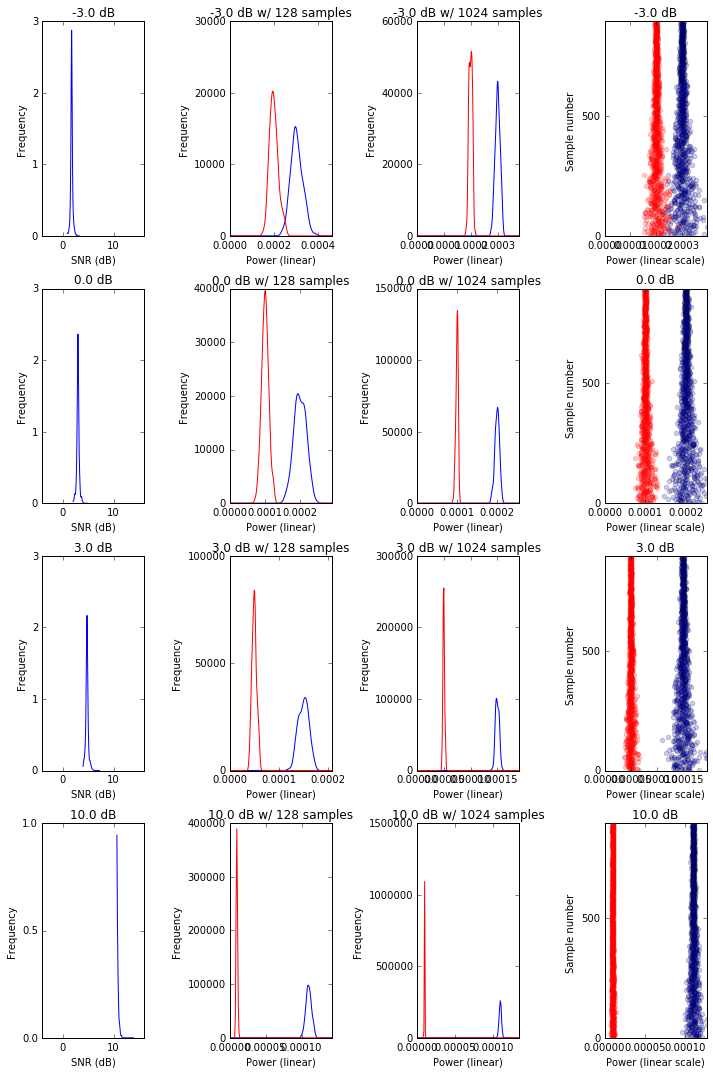

In [104]:
snrlist = [-3,0,3,10]
ndatalist = [64, 128, 256, 512, 1024, 2048, 4096]
f, axtuple = plt.subplots(len(snrlist), 4, figsize=(10, 15))


for ax_idx, snr_desired in enumerate(snrlist):        

    # Get lists of sample files for the given SNR and read in the samples into array
    noise_files = ["samples/samples_%.1fdb_%d_128_noise.npy" % (snr_desired, n) for n in ndatalist]
    signal_files = ["samples/samples_%.1fdb_%d_128_signal.npy" % (snr_desired, n) for n in ndatalist]
    sn_files = ["samples/samples_%.1fdb_%d_128_sn.npy" % (snr_desired, n) for n in ndatalist]
    
        
        # NESTED LOOP PATTERN: [len(WORD) for LINE in FILE for WORD in LINE]
    noise_power_array = [compute_power(j) for f in noise_files for i,j, in enumerate(np.load(f))]
    sn_power_array = [compute_power(j) for f in sn_files for i,j, in enumerate(np.load(f))]    
    signal_power_array = [compute_power(j) for f in signal_files for i,j, in enumerate(np.load(f))]    
    #print([x/y for x,y in zip(signal_power_array, noise_power_array)])
    
    # Read in data for experiments where we save just ndata=128 samples
    noise_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_128" + "*noise.npy"
    noise_files_128 = [file for file in glob.glob(noise_pattern)]
    noise_power_128 = [compute_power(j) for f in noise_files_128 for i,j, in enumerate(np.load(f))]

    sn_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_128" + "*sn.npy"
    sn_files_128 = [file for file in glob.glob(sn_pattern)]
    sn_power_128 = [compute_power(j) for f in sn_files_128 for i,j, in enumerate(np.load(f))]

    # Read in data for experiments where we save just ndata=1024 samples
    noise_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_1024" + "*noise.npy"
    noise_files_1024 = [file for file in glob.glob(noise_pattern)]
    noise_power_1024 = [compute_power(j) for f in noise_files_1024 for i,j, in enumerate(np.load(f))]

    sn_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_1024" + "*sn.npy"
    sn_files_1024 = [file for file in glob.glob(sn_pattern)]
    sn_power_1024 = [compute_power(j) for f in sn_files_1024 for i,j, in enumerate(np.load(f))]

    
    # plot SNR density for each SNR value
    plot_snr_density(noise_power_array, sn_power_array, axtuple[ax_idx][0], title = "%.1f dB" % snr_desired)
    
    # plot density for trials with 128 samples for each SNR value
    plot_density(noise_power_128, sn_power_128, axtuple[ax_idx][1], title = "%.1f dB w/ 128 samples" % snr_desired)
    
     # plot density for trials with 128 samples for each SNR value
    plot_density(noise_power_1024, sn_power_1024, axtuple[ax_idx][2], title = "%.1f dB w/ 1024 samples" % snr_desired)
    
    # plot avg power of noisy signal, noise for each SNR value
    plot_avg_pwr(noise_power_array, sn_power_array, axtuple[ax_idx][3], title = "%.1f dB" % snr_desired)
    
    

plt.tight_layout()


### (to come) Theory behind Q-PSK and constellation
### (to come) Formula forAvg Power
 
> Some Notes

>*Explanation of Experiment to come*

>    Reading; seems relevant to what Fraida  was talking about; useful for writing "Q-PSK" theory section; avg energy theory; 
    http://web.stanford.edu/group/cioffi/doc/book/chap1.pdf
    
>    Will clean up "Generate Qpsk samples" code later

>   Just want to get working classifier

> Nxt part of expr will deal with using better data to make classifier better -- the non-random characteristics

Kimberly Devi Milner

EE Independent Study w/  Fraida Fund

# Radio Machine Learning: Modeling the presence of a primary user as a  classification problem


# Theretical Background
**ATTRIBUTION:** Images and references from https://ctvrie.files.wordpress.com/2013/07/cograd_commtheory_2013.pdf

### What is a cognitive radio?
A cognitive radio is a radio that is aware of its environemnt. 

Cognitive radios (CR) can dynamically and autonomously adjust radio parameters to interact with the environment around it. In this way CRs can decide the optimal carrier frequency and bandwidth to guide the signal to its end to end communication. 

### Why do we need cognitive radios?
CISCO foresees a x1000 increase in wireless traffic by 2020. The licensed and unlicensed spectrum cannot grow at this rate. 

Cognitive radios provide several solutions to this dilemma; one including a mechanism to take advantage of spectrum holes -- a point in frequency, time or space -- which is not occupied by any transmission. 

### How  could Cognitive Radios work?

#### Spectrum Awareness
The cognitive/secondary radio can learn about its environment by observing characteristics of the primary uers's channel. These characteristics include:
    * Traffic Patterns
    * Signaling Procedures
    * Channel Conditions
    * (parts of) messages sent by the legacy system


#### Transmitting the Secondary Signal

There are 3 protocols for the secondary user to transmit signals, which break down into "margin" operations and "help" operations.


###### Image References
> * P/STX = primary/secondary transmitter
> * P/SRX = primary/secondary receiver

$$MARGIN:$$
** Underlaying: ** The secondary user's interference to the licensed user's is not avoided, but controlled. The secondary user's intereference should go below the noise floor.
> The difficulty here is due to the fact that the exact interference situation at the primary receiver is not known.

<img src="interweave_2.png">  

** Interleaving: ** Interference by the secondary user is avoided and the secondary user seeks  opportunistic/orthogonal transmission through spectrum holes.
<img src="underlay.png">

$$HELP:$$
** Overlaying: ** The Cognitive Radio knows much more about the primary system (like what message it is sending) and can possibly retransmit this message. 
<img src="overlay.png"> 




# How can we effectively detect whether or not there is another user present on the spectrum that we want to use?

**REFERENCES:** (chapter 2 of Cognitive Radio Book)

*Biglieri, E., Goldsmith, A.J., Greenstein, L.J., Mandayam, N.B. and Poor, H.V. (2012) ‘Capacity of cognitive radio networks’, in Principles of Cognitive Radio:. Cambridge: Cambridge University Press, pp. 41–101.*


## What is  energy sensing 

**Energy sensing**  tries to determine the presence of a spectrum hole by comparing the measured energy of the primary channel against a threshold set for primary-user-presence.

The primary-user-presence "threshold depends on the observed-signal model and hence on the noise variance" (157).
So an error made in the estimation of the noise variance will degrade the performance of an engergy detector.

But as the energy detector cannot discriminate between signal and noise, it is more likely to make errors in estimating noise variance, especially at low SNRs, and perform worse.
 
## What is Signal-to-Noise Ratio (SNR),  also known as channel gain?
$$SNR= \frac{signalPower}{noisePower}$$ 


Channel gain is the amplification or attenuation of a signal on a channel:

Channel gain(H) for channel(S,R)  is: $$Y = HX + Z(noise),$$ where Y is the  signal received.



# Loading an AWGN PSK signal generated on GNU radio 
<img src="inp_vs_noise_vs_output.png">